# Gradients

In [28]:
%matplotlib notebook

In [96]:
# imports
from pkg_resources import resource_filename
from importlib import reload

import os
import numpy as np
import json

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import seaborn as sns

import pandas

from skimage import filters
import xarray

from ulmo import plotting
from ulmo import io as ulmo_io
from ulmo.preproc import utils as pp_utils
from ulmo.preproc import io as pp_io

# Setup

In [16]:
eval_path = os.path.join(os.getenv('SST_OOD'), 'Evaluations')
modis_path = os.path.join(os.getenv('SST_OOD'), 'MODIS')

In [26]:
field_size=(128,128)

In [31]:
pal, cm = plotting.load_palette()

## Pre-processing steps

In [81]:
reload(pp_io)
std_preproc = pp_io.load_options('preproc_standard.json')
# Turn on inpainting
std_preproc['inpaint'] = True
std_preproc

{'downscale': True,
 'dscale_size': (2, 2),
 'inpaint': True,
 'med_size': (3, 1),
 'median': True,
 'only_inpaint': False}

In [82]:
grad_preproc = std_preproc.copy()
grad_preproc['gradient'] = True
grad_preproc

{'downscale': True,
 'dscale_size': (2, 2),
 'inpaint': True,
 'med_size': (3, 1),
 'median': True,
 'only_inpaint': False,
 'gradient': True}

## Find a few images to examine

In [4]:
eval_file = os.path.join(eval_path, 'MODIS_R2019_2010_95clear_128x128_preproc_std_log_probs.csv')

### Load probs

In [6]:
df = pandas.read_csv(eval_file)
df.head()

,filename,row,column,latitude,longitude,clear_fraction,mean_temperature,log_likelihood
0,AQUA_MODIS.20100814T041508.L2.SST.nc,592,325,-47.681175,-53.480907,0.029785,8.029080,-484.02140
1,AQUA_MODIS.20100103T093507.L2.SST.nc,1520,965,21.502030,-113.207596,0.028992,23.081547,-107.59717
2,AQUA_MODIS.20100929T154508.L2.SST.nc,944,389,-0.395960,144.915540,0.007019,29.277092,289.92242
3,AQUA_MODIS.20101224T020508.L2.SST.nc,304,933,-24.620580,-7.820027,0.028259,22.367168,51.23877
4,AQUA_MODIS.20100626T031000.L2.SST.nc,1855,820,20.623140,-19.356192,0.049683,21.428528,-75.73401


### Find the outliers/inliers

In [8]:
srt_log = np.argsort(df.log_likelihood)

In [10]:
outliers = srt_log[0:10]
inliers = srt_log[-10:]

In [12]:
df.iloc[outliers]

,filename,row,column,latitude,longitude,clear_fraction,mean_temperature,log_likelihood
43769,AQUA_MODIS.20100228T070500.L2.SST.nc,1086,384,31.609312,-80.02649,0.049805,15.167435,-3568.1824
247531,AQUA_MODIS.20100228T070500.L2.SST.nc,1082,389,31.634724,-79.95622,0.049744,15.479530,-3469.0063
403705,AQUA_MODIS.20100430T063508.L2.SST.nc,63,210,35.384960,-73.89222,0.049438,21.494633,-3440.3530
376236,AQUA_MODIS.20100228T070500.L2.SST.nc,1094,383,31.534885,-80.05114,0.049988,15.363752,-3345.7412
233149,AQUA_MODIS.20100228T070500.L2.SST.nc,1093,389,31.535467,-79.97866,0.049683,15.890407,-3246.2260
34489,AQUA_MODIS.20101112T075008.L2.SST.nc,1552,197,13.903409,-97.06816,0.036255,26.384579,-3059.1924
99982,AQUA_MODIS.20101024T071508.L2.SST.nc,671,1025,35.398342,-74.03404,0.049561,26.062084,-2925.4102
260716,AQUA_MODIS.20100228T070500.L2.SST.nc,1178,360,30.826292,-80.50698,0.049377,16.205540,-2888.7722
76909,AQUA_MODIS.20101112T075008.L2.SST.nc,1520,197,14.194087,-97.01158,0.037659,26.247946,-2821.2590
447689,AQUA_MODIS.20101112T075008.L2.SST.nc,1488,261,14.369994,-96.09466,0.046875,24.032898,-2785.8994


In [14]:
df.iloc[srt_log[-20:]]

,filename,row,column,latitude,longitude,clear_fraction,mean_temperature,log_likelihood
487939,AQUA_MODIS.20100804T051508.L2.SST.nc,1456,645,-49.563583,-64.824524,0.001160,6.431276,858.43933
68946,AQUA_MODIS.20100813T051008.L2.SST.nc,1008,581,-49.667564,-64.281950,0.002808,6.195672,861.68040
93382,AQUA_MODIS.20100815T050008.L2.SST.nc,48,357,-49.141575,-64.455894,0.001343,6.434693,861.80720
502501,AQUA_MODIS.20100804T051508.L2.SST.nc,1456,677,-49.626200,-64.378780,0.000793,6.413826,862.01960
270438,AQUA_MODIS.20100813T051008.L2.SST.nc,976,581,-49.389000,-64.164180,0.002930,6.236574,866.64404
226872,AQUA_MODIS.20100804T051508.L2.SST.nc,1328,709,-48.567880,-63.501247,0.000793,6.427714,868.12836
95623,AQUA_MODIS.20100815T050008.L2.SST.nc,80,357,-49.417780,-64.593310,0.002502,6.432520,869.46720
483935,AQUA_MODIS.20100815T050008.L2.SST.nc,112,357,-49.695570,-64.731350,0.007629,6.399454,870.73690
192547,AQUA_MODIS.20100625T222008.L2.SST.nc,496,965,8.375247,53.601833,0.002258,28.257088,872.45514
193332,AQUA_MODIS.20100804T051508.L2.SST.nc,1360,677,-48.787820,-64.048996,0.000183,6.457434,874.41630


### Grabbed the images with scp

# Examine Gradient images

## defs

In [109]:
def show_pp(filename, row, col, field_size=(128,128)):
    # Load
    sst, qual, latitude, longitude = ulmo_io.load_nc(filename)
    # Field 128x128 
    field = sst[row:row+field_size[0], col:col+field_size[1]]
    # Mask
    masks = pp_utils.build_mask(sst, qual)
    mask = masks[row:row+field_size[0], col:col+field_size[1]]
    # Pre-process
    pp_field, meta = pp_utils.preproc_field(field.copy(), mask.copy(), **std_preproc)
    grad, gmeta = pp_utils.preproc_field(field.copy(), mask.copy(), **grad_preproc)
    
    # Plot
    fig = plt.figure(figsize=(10, 4))

    plt.clf()
    gs = gridspec.GridSpec(1,2)

    ax1 = plt.subplot(gs[0])
    sns.heatmap(pp_field, ax=ax1, xticklabels=[], yticklabels=[], cmap=cm)#, vmin=-2, vmax=2)

    ax2 = plt.subplot(gs[1])
    sns.heatmap(grad, ax=ax2, xticklabels=[], yticklabels=[], cmap=cm)#, vmin=-2, vmax=2)

    plt.show()

## Outliers

### First example

In [110]:
o1_file = os.path.join(modis_path, 'AQUA_MODIS.20100228T070500.L2.SST.nc')
row_o1, col_o1 = 1082, 389

<IPython.core.display.Javascript object>


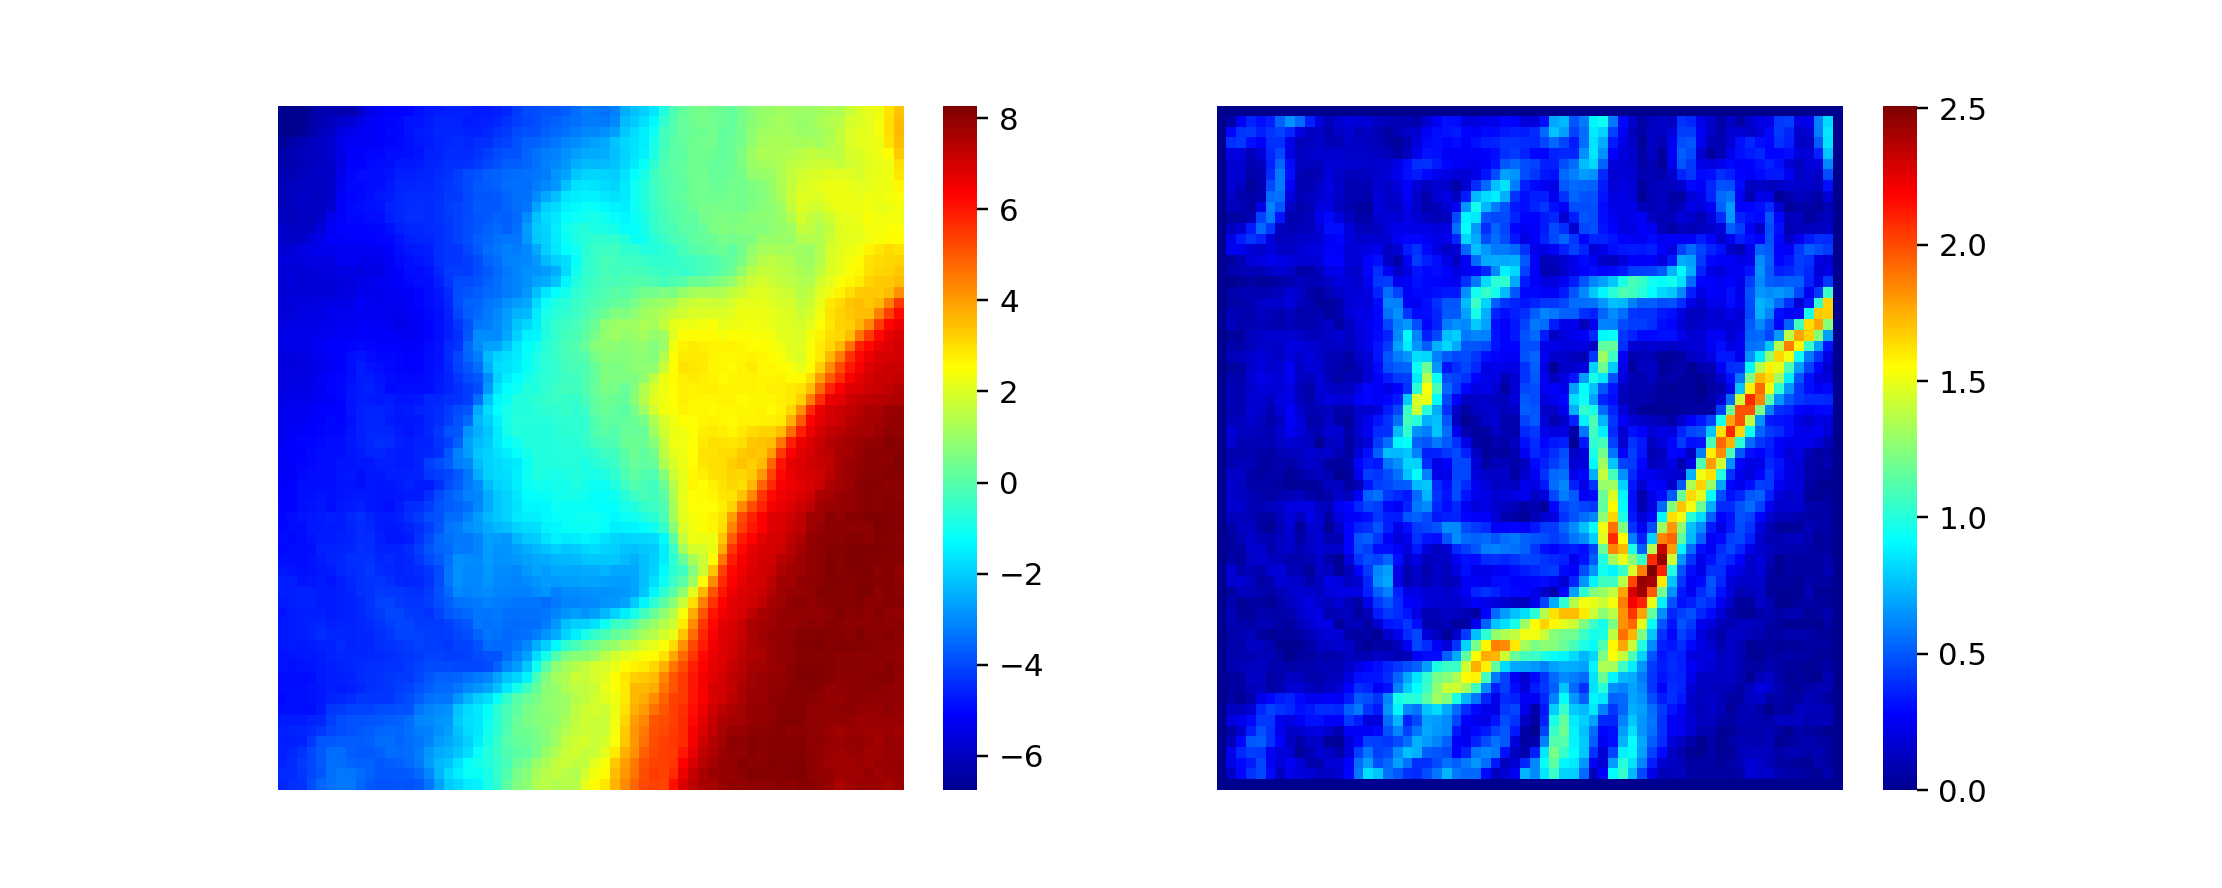

In [111]:
show_pp(o1_file, row_o1, col_o1)

### Another

In [114]:
o2_file = os.path.join(modis_path, 'AQUA_MODIS.20101024T071508.L2.SST.nc')
row_o2, col_o2 = 671, 1025

<IPython.core.display.Javascript object>


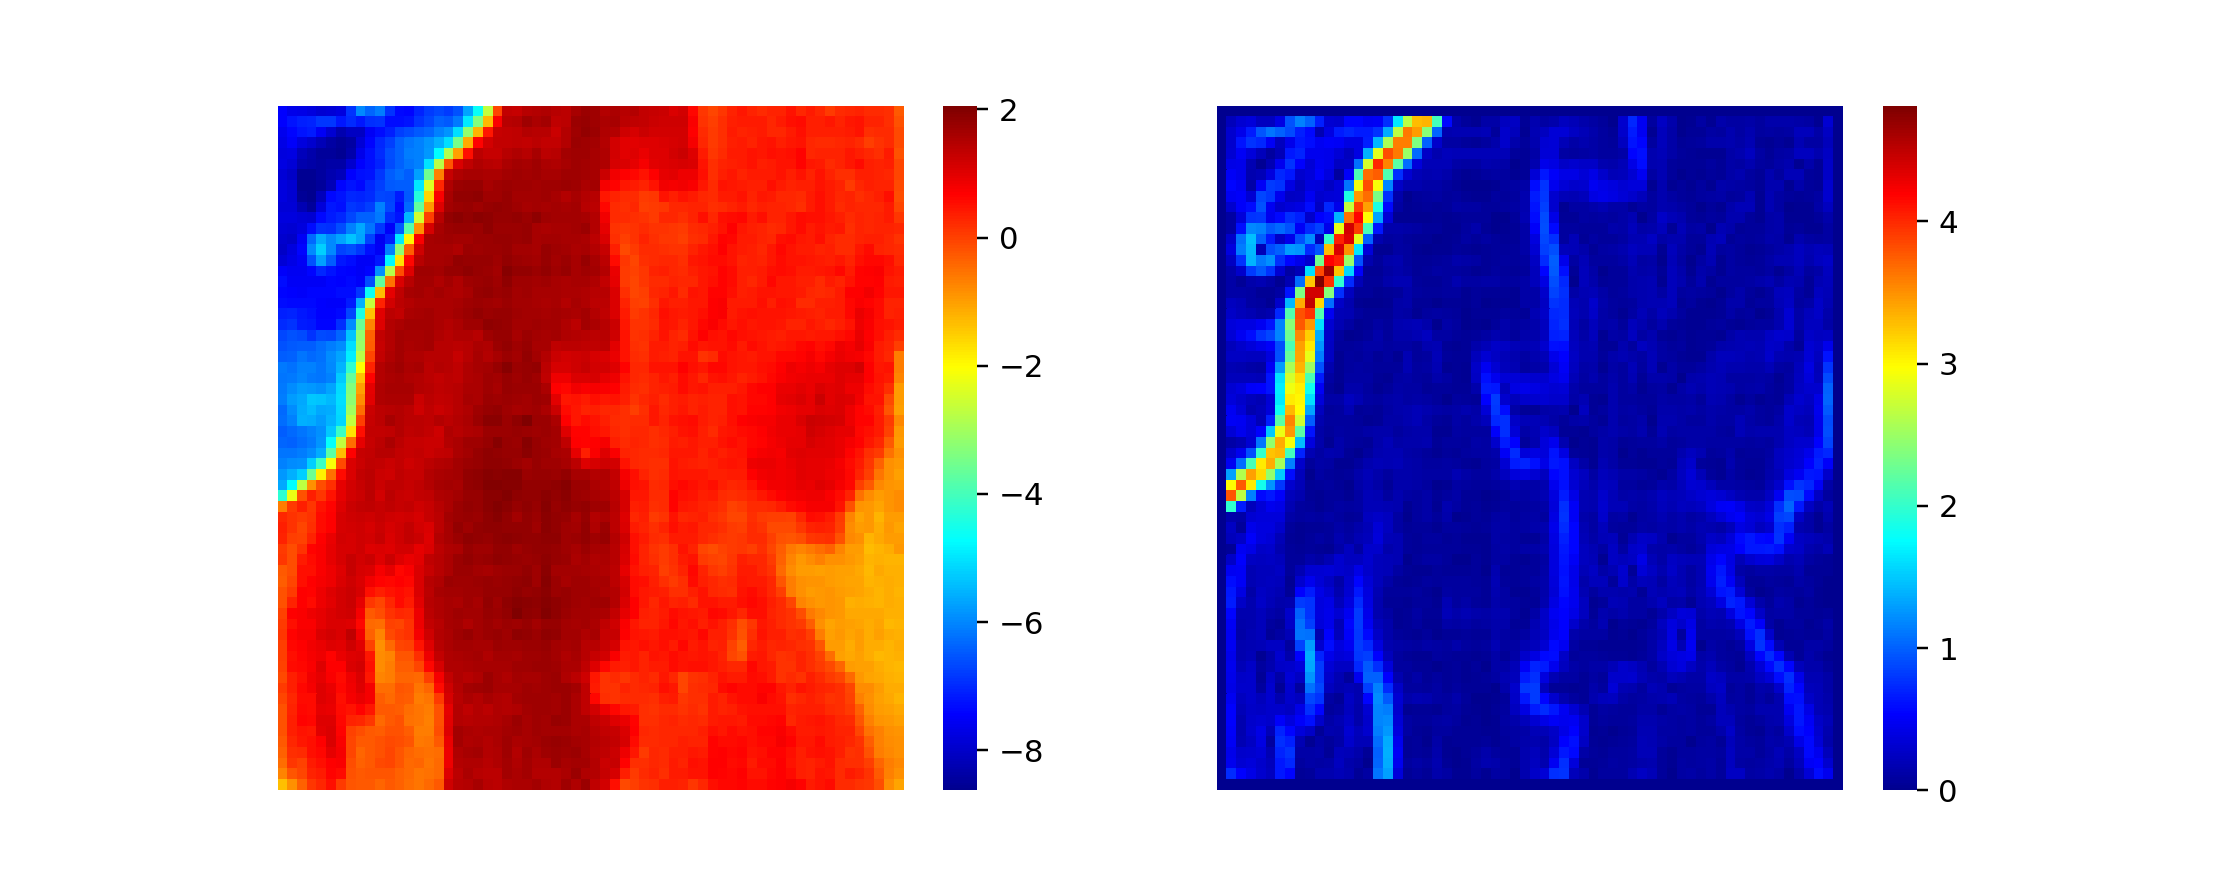

In [115]:
show_pp(o2_file, row_o2, col_o2)

## Inliers

In [116]:
i1_file = os.path.join(modis_path, 'AQUA_MODIS.20100804T051508.L2.SST.nc')
row_i1, col_i1 = 1520,709 

<IPython.core.display.Javascript object>


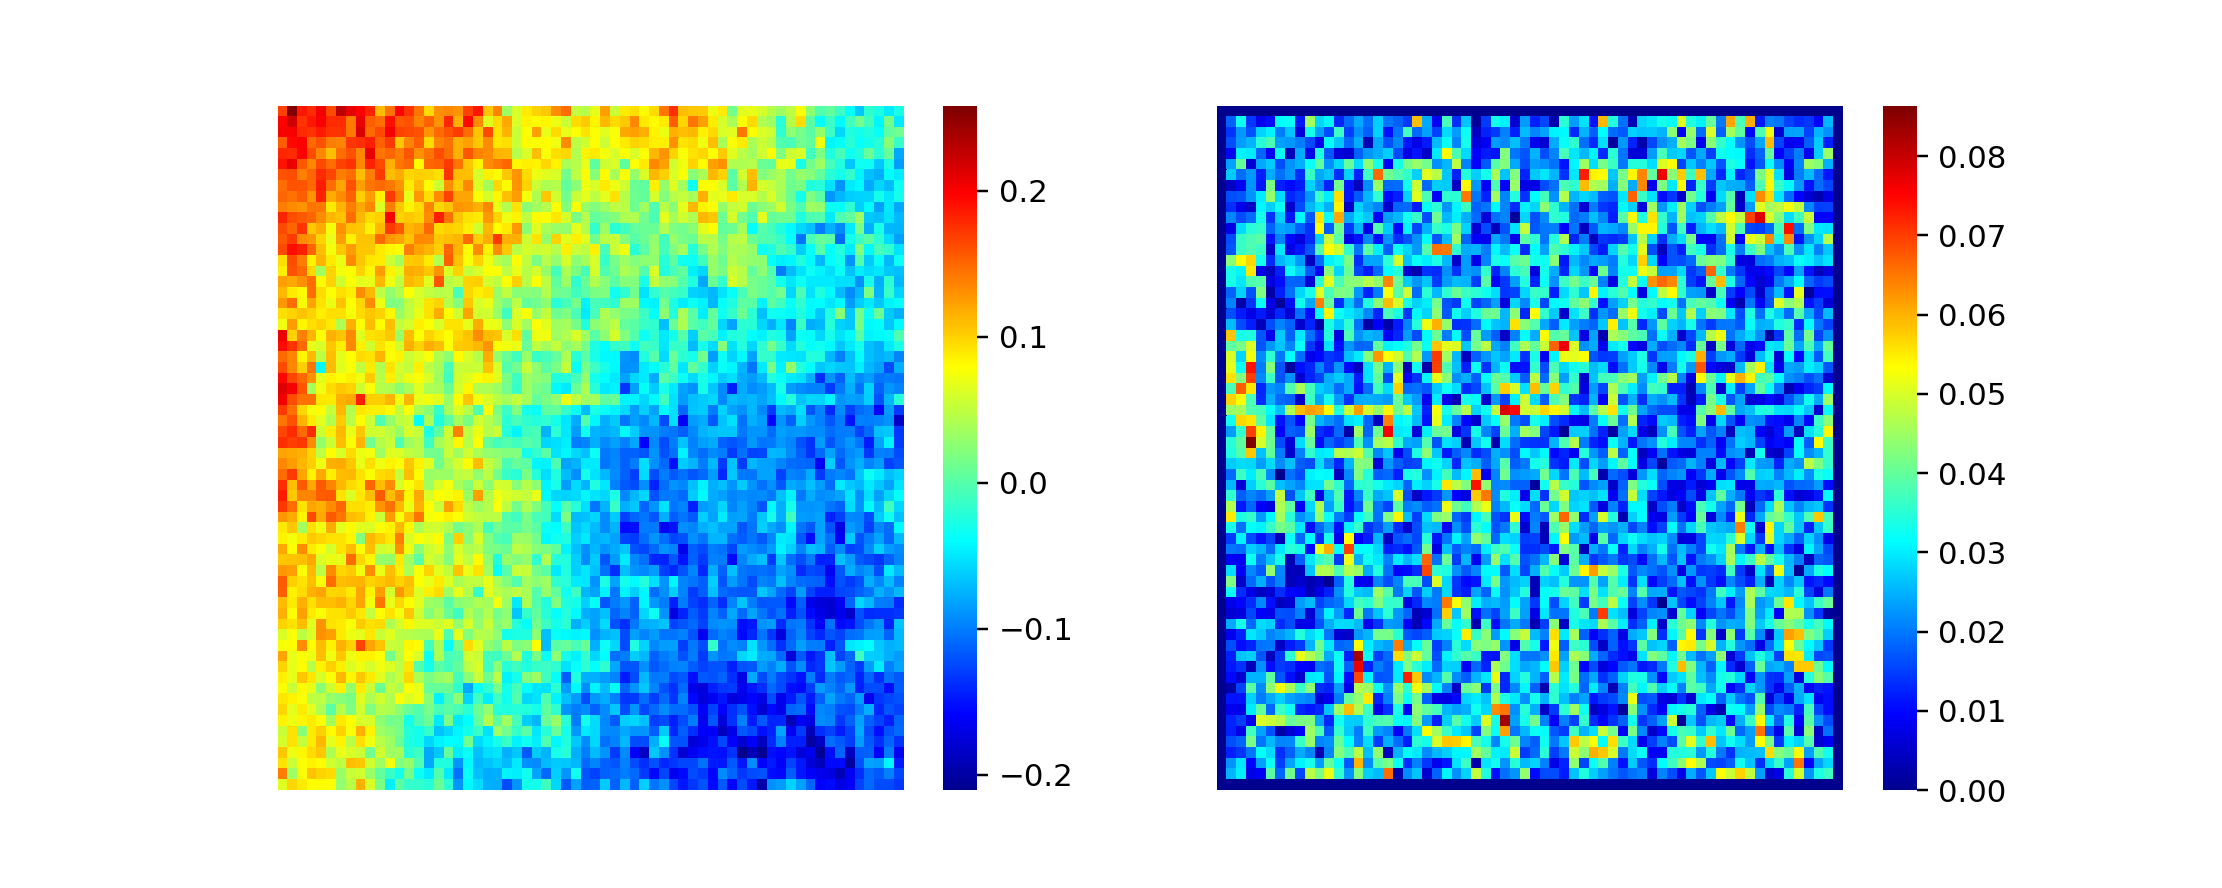

In [117]:
show_pp(i1_file, row_i1, col_i1)

In [118]:
i2_file = os.path.join(modis_path, 'AQUA_MODIS.20100625T222008.L2.SST.nc')
row_i2, col_i2 = 496, 965

<IPython.core.display.Javascript object>


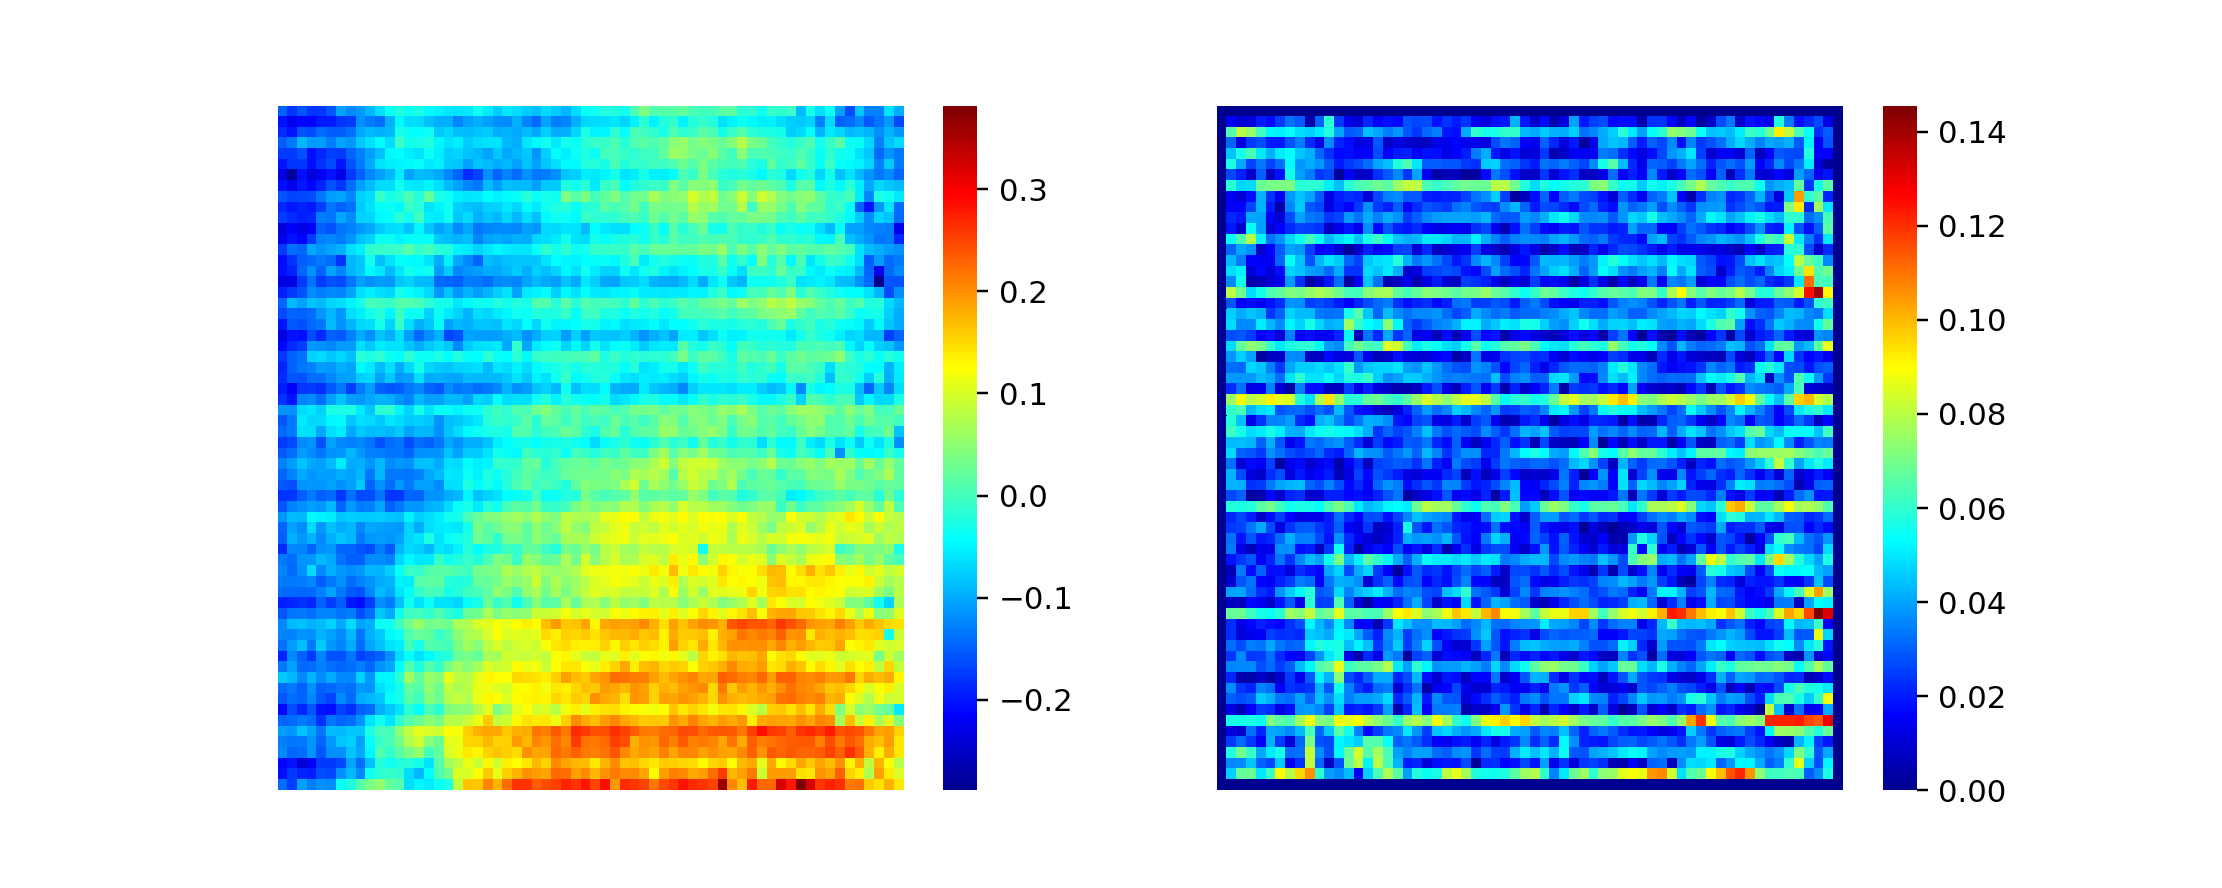

In [119]:
show_pp(i2_file, row_i2, col_i2)

----

# Test extraction